The code below uses an LSTM model to predict trajectories.

Susanna Lange

In [ ]:
import pandas as pd
from pandas import read_csv
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import time as time
from sklearn.preprocessing import MinMaxScaler
import keras
from pandas import datetime
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout, RepeatVector, TimeDistributed, Masking
from keras import metrics
import math
from math import *



<ipython-input-139-20aba8d6dc4d>:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


Below are the code parameters currently used in the model. There are options to tune the model (or change the parameters slightly) to achieve better results. We will focus on those below:

In [ ]:
n_pre = 100  #number of time steps feeding in 

#possible options: 100, 500, 1000, 2000

n_post = 10  #number of time steps predicting

#possible options(depends on n_pre as well): 10, 20, 50, 100 (can the model predict half the input sequence, or 1/3?)

window = 5 #this controls the amount of overlap between shifted sequences.

#possible options(depends on missing data, we don't want to shift our sequence and get a new sequence with no new info) 50, 100, 200

lr = 0.001 # learning rate

#learning rate can quickly change the model results! possible options: 0.01, 0.001, 0.0001, 0.00001

opt = keras.optimizers.RMSprop(learning_rate=lr)

#possible options = [keras.optimizers.Adam(learning_rate=lr), keras.optimizers.SGD(learning_rate=lr), keras.optimizers.RMSprop(learning_rate=lr)]

bs = 10 #batchsize

#possible options: 32, 64, 128, 256 (the larger the batch size, the quicker the code usually runs...)

epoch_number = 10 #number of epochs to train for

#posible options: 100, 500

hidden_neurons = 200 #neurons in the model

#possible options: 100, 200


## Model defined

In [ ]:
def create_model(steps_before, steps_after, hidden_neurons, opt):
    """ 
        creates, compiles and returns a RNN model 
        @param steps_before: the number of previous time steps (input)
        @param steps_after: the number of posterior time steps (output or predictions)
        @param feature_count: the number of features in the model
        @param hidden_neurons: the number of hidden neurons per LSTM layer
    """
   # DROPOUT = 0.5
    LAYERS = 2

    model = Sequential()
    model.add(Masking(mask_value=-999)) 
    model.add(LSTM(hidden_neurons, input_shape = (steps_before, None),return_sequences=False))

    model.add(RepeatVector(steps_after)) 

    model.add(LSTM(hidden_neurons, return_sequences=True)) 
    model.add(TimeDistributed(Dense(8))) 
    model.add(Activation('relu'))
 
    
    model.compile(loss='mean_squared_error', optimizer=opt)  
    return model

## Preprocessing Functions

In [ ]:
## additional preprocessing functions below
def delete_id(traj_data):
  del traj_data['trajectory_id']
  return traj_data

def daySeconds(x):
  """returns number of seconds since beginning of the day """
  return 3600*x.tm_hour+60*x.tm_min+x.tm_sec

def circularizeTime(traj_data):
  """This function translates the time data in the trajectory data from a string to a few numeric columns of a DataFrame
    The first column unix_time counts seconds from a fixed date Dec 31st, 1969. 

    The columns day_clock_x and day_clock_y translate the 24 hours in a day into the position of the hand of a clock that completes a rotation once a day,
    this makes it easier for the network to observe trends that depend on the time of day.
    The columns year_clock_x and year_clock_y do the same if the hand of the clock completed a cycle once a year."""

  traj_data['unix_time'] = traj_data.apply(lambda traj:time.mktime(time.strptime(traj.time, '%Y-%m-%d %H:%M:%S')),axis=1)

  traj_data['year_day'] = traj_data.apply(lambda traj: time.strptime(traj.time,  '%Y-%m-%d %H:%M:%S').tm_yday,axis=1)
  traj_data['year_clock_x'] = traj_data.apply(lambda traj: np.cos(2*np.pi*traj.year_day/365), axis=1)
  traj_data['year_clock_y'] = traj_data.apply(lambda traj: np.sin(2*np.pi*traj.year_day/365), axis=1)
  del traj_data['year_day']


  traj_data['day_sec'] = traj_data.apply(lambda traj: daySeconds(time.strptime(traj.time,  '%Y-%m-%d %H:%M:%S')),axis=1)
  traj_data['day_clock_x'] = traj_data.apply(lambda traj: np.cos(2*np.pi*traj.day_sec/(24*60*60)),axis=1)
  traj_data['day_clock_y'] = traj_data.apply(lambda traj: np.sin(2*np.pi*traj.day_sec/(24*60*60)),axis=1)
  del traj_data['day_sec']
  scaler = MinMaxScaler(feature_range=(0, 1))
  traj_data[['unix_time']] = scaler.fit_transform(traj_data[['unix_time']])
  del traj_data['time']
  return traj_data

# Helper function 1: Calculating distance
def haversine(d1, d2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    data1 = np.deg2rad(d1)                     
    data2 = np.deg2rad(d2)                     

    lat1 = data1[:,0]                     
    lng1 = data1[:,1]         
    
    lat2 = data2[:,0]                     
    lng2 = data2[:,1]         

    diff_lat = lat2 - lat1 
    diff_lng = lng2 - lng1 
    d = np.sin(diff_lat/2)**2 + np.cos(lat1)*np.cos(lat2) * np.sin(diff_lng/2)**2
    distance = 2 * 6371 * np.arcsin(np.sqrt(d))
    return distance

# Helper function 2: Calculating bearing
def bearing(d1, d2):
    """
    Calculate the bearing between two points 
    Modified based on: https://stackoverflow.com/questions/68366232/difference-in-calculating-bearing
    """         
    lat1 = d1[:,0]
    lng1 = d1[:,1] 
    
    lat2 = d2[:,0]                     
    lng2 = d2[:,1] 
    
    dLon = lng2 - lng1
    y = np.cos(np.radians(lat1)) * np.sin(np.radians(lat2)) - np.sin(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.cos(np.radians(dLon))
    x = np.cos(np.radians(lat2)) * np.sin(np.radians(dLon))
    brng = np.degrees(np.arctan2(x, y)) + 180
    return brng

# Main function 
def data_transformation(dataframe, trajectory_col_name, lat_col_name, lon_col_name):
    """
    To convert each latitude/longitude coordinate pair to a distance 
    value and a bearing value relative to the previous coordinate pair
    Input:
    - Pandas DataFrame
    - Three strings: trajectory_col_name, lat_col_name, lon_col_name
    Output:
    - A new DataFrame
    """
    # Make a copy of the data frame
    df_new = dataframe.copy()
    
    # Create 2 arrays - one with original index, one with shifting index 
    d1 = np.array(dataframe[[lat_col_name, lon_col_name]])
    next_df = dataframe.shift(1)
    d2 = np.array(next_df[[lat_col_name,lon_col_name]])

    # Calculations
    df_new['distance'] = haversine(d1, d2).tolist()
    df_new['bearing'] = bearing(d1, d2).tolist()
    del df_new['latitude']
    del df_new['longitude']
    return df_new


Suppose we have 10 different trajectories we want to use to train the model. Then for each trajectory, we run it through the create_dataset function (which creates the staggered window of training and test data) and then join each together in a batch.

In [ ]:
def create_dataset(dataset, n_pre, n_post, window):
  """Creates training and testing data by shifting dependent on window input""" 
  dX, dY = [], []
  for i in range(0, len(dataset)-n_pre-n_post, window):  #step size is controlled by window
    dX.append(dataset[i:i+n_pre]) 
    dY.append(dataset[i+n_pre:i+n_pre+n_post]) 
  return [np.array(dX)], [np.array(dY)]        



In [ ]:
def create_batches(trajectories_array, n_pre, n_post, window):

  for i in range(0, len(trajectories_array)): #for each of the trajectories
      if i==0:
        dataX_batches, dataY_batches = create_dataset(trajectories_array[i], n_pre, n_post, window)
      if i != 0:
        dataX, dataY = create_dataset(trajectories_array[i], n_pre, n_post, window)
        dataX_batches = np.append(dataX_batches, dataX, axis=0)
        dataY_batches = np.append(dataY_batches, dataY, axis=0)
  if len(trajectories_array) == 1: 
    dataX_batches = np.array(dataX_batches)   

  (uniq_t,windowed,time,feat) = dataX_batches.shape
  dataX_batches = np.reshape(dataX_batches, (uniq_t*windowed,time,feat), order = 'C')
  dataY_batches = np.reshape(dataY_batches, (uniq_t*windowed,n_post,feat), order = 'C') 
          
  return dataX_batches, dataY_batches 

# Maine

### Here we can load in the data and incorporate more preprocessing functions

In [ ]:
##REPLACE BELOW WITH OUR SIMULATED DATA
# load the dataset.
input_file="trajectories_2020-01-01_seed222_500pts_maine.csv"
maine_traj = read_csv(input_file, delimiter=',')
del maine_traj['fishery']

maine_traj = maine_traj.rename(columns={'lat': "latitude", 'lon': "longitude", "trajectory": "trajectory_id"})
maine_traj = data_transformation(maine_traj, "trajectory_id", "latitude", "longitude")
maine_traj = maine_traj.fillna(0)
maine_traj.head()

,trajectory_id,time,temperature,distance,bearing
0,1,2020-01-01 00:30:00,0.882706,0.000000,0.000000
1,1,2020-01-01 01:30:00,0.882706,0.214009,272.725454
2,1,2020-01-01 02:30:00,0.893610,0.230455,274.326740
3,1,2020-01-01 03:30:00,0.901265,0.251455,275.419291
4,1,2020-01-01 04:30:00,0.912216,0.296286,277.236112


In [ ]:
###REPLACE THE BELOW WITH PREPROCESSING FUNCTIONS
scaler = MinMaxScaler(feature_range=(0, 1))
maine_traj[['distance', 'bearing', 'temperature']] = scaler.fit_transform(maine_traj[['distance', 'bearing','temperature']])
maine_traj.head()

,trajectory_id,time,temperature,distance,bearing
0,1,2020-01-01 00:30:00,0.126601,0.000000,0.000000
1,1,2020-01-01 01:30:00,0.126601,0.000182,0.757571
2,1,2020-01-01 02:30:00,0.127091,0.000196,0.762019
3,1,2020-01-01 03:30:00,0.127435,0.000214,0.765054
4,1,2020-01-01 04:30:00,0.127926,0.000252,0.770100


In [ ]:
## Functions to be used on a single trajectory
maine_traj = delete_id(maine_traj)
maine_traj = circularizeTime(maine_traj)
maine_traj_array = maine_traj.to_numpy() # this is still a single trajectory


In [ ]:
maine_traj_array = np.reshape(maine_traj_array, (500, -1, 8), order = 'C')

In [ ]:
dataX_batches, dataY_batches = create_batches(maine_traj_array, n_pre, n_post, window)

In [ ]:
dataX_batches.shape

(63500, 100, 8)

## Here is where we train the model

In [ ]:
# create and fit the LSTM network
EPOCHS = epoch_number
print('creating model...')
model = create_model(n_pre, n_post, hidden_neurons,opt)
   

creating model...


In [ ]:
#perhaps create validation data separately rather than as part of training....currently biased (should be less biased when with more data)
history = model.fit(dataX_batches, dataY_batches, batch_size=bs, epochs=epoch_number, validation_split=0.2) 
# history = model.fit(dataX_batches, dataY_batches, batch_size=bs, epochs=1, validation_split=0.2) 


Epoch 1/10
5080/5080 [==============================] - 955s 188ms/step - loss: 0.0677 - val_loss: 0.0674
Epoch 2/10
5080/5080 [==============================] - 966s 190ms/step - loss: 0.0674 - val_loss: 0.0670
Epoch 3/10
5080/5080 [==============================] - 983s 193ms/step - loss: 0.0671 - val_loss: 0.0669
Epoch 4/10
5080/5080 [==============================] - 942s 185ms/step - loss: 0.0668 - val_loss: 0.0667
Epoch 5/10
5080/5080 [==============================] - 990s 195ms/step - loss: 0.0667 - val_loss: 0.0668
Epoch 6/10
5080/5080 [==============================] - 985s 194ms/step - loss: 0.0665 - val_loss: 0.0666
Epoch 7/10
5080/5080 [==============================] - 1034s 204ms/step - loss: 0.0664 - val_loss: 0.0663
Epoch 8/10
5080/5080 [==============================] - 1087s 214ms/step - loss: 0.0663 - val_loss: 0.0662
Epoch 9/10
5080/5080 [==============================] - 1032s 203ms/step - loss: 0.0662 - val_loss: 0.0662
Epoch 10/10
5080/5080 [====================

In [ ]:
# Save the model 
# model.save('my_model.h5') 
model.save('my_model_maine_2.h5') 

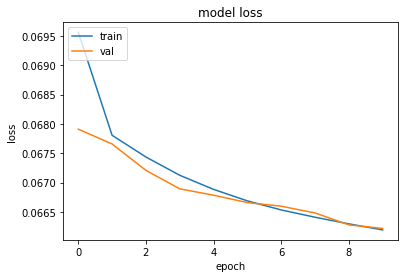

In [ ]:
#for plotting loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Example of using the model to predict a single trajectory

In [ ]:
model = keras.models.load_model('my_model_maine_2.h5')


In [ ]:
maine_test = read_csv("maine_test.csv", delimiter=',')
del maine_test['fishery']

maine_test = maine_test.rename(columns={'lat': "latitude", 'lon': "longitude", "trajectory": "trajectory_id", 
                                        "water_temperature_mean": "temperature", "datetime": "time"})
maine_test = data_transformation(maine_test, "trajectory_id", "latitude", "longitude")
maine_test = maine_test.fillna(0)
maine_test.head()

,time,temperature,trajectory_id,distance,bearing
0,2022-08-29 11:41:06,14.0,1,0.000000,0.000000
1,2022-08-30 11:43:39,14.0,1,0.056318,339.692187
2,2022-08-31 11:52:36,14.0,1,0.059149,151.391998
3,2022-09-01 11:54:37,15.0,1,0.005861,107.670735
4,2022-09-02 11:58:46,14.0,1,0.033537,321.793558


In [ ]:
###REPLACE THE BELOW WITH PREPROCESSING FUNCTIONS
scaler = MinMaxScaler(feature_range=(0, 1))
maine_test[['distance', 'bearing', 'temperature']] = scaler.fit_transform(maine_test[['distance', 'bearing','temperature']])
maine_test.head()

,time,temperature,trajectory_id,distance,bearing
0,2022-08-29 11:41:06,0.50,1,0.000000,0.000000
1,2022-08-30 11:43:39,0.50,1,0.003778,0.947136
2,2022-08-31 11:52:36,0.50,1,0.003968,0.422114
3,2022-09-01 11:54:37,0.75,1,0.000393,0.300210
4,2022-09-02 11:58:46,0.50,1,0.002250,0.897231


In [ ]:
## Functions to be used on a single trajectory
maine_test = delete_id(maine_test)
maine_test = circularizeTime(maine_test)
maine_test_array = maine_test.to_numpy() # this is still a single trajectory


In [ ]:
maine_test_array = np.reshape(maine_test_array, (1, -1, 8), order = 'C')

In [ ]:
dataX_batches_test, dataY_batches_test = create_batches(maine_test_array, n_pre, n_post, window)

In [ ]:
#Send a single trajectory through the model using model.predict
# y=np.expand_dims(dataX_batches[0][0:50], axis=0)

y=np.expand_dims(dataX_batches_test[0], axis = 0)
predict = model.predict(y)


The results of predict above, are the predicted trajectories. To see them, we need to transform back to un-normalized results. The code below prints the input y, the actual next 10 steps, and the predicted next 10 steps.

In [ ]:
dataframe_traj=pd.DataFrame(dataX_batches_test[0], columns=['distance', 'bearing', 'temp','unix_time', 'year_clock_x', 'year_clock_y', 'day_clock_x', 'day_clock_y']) 

dataframe_traj[['distance', 'bearing', 'temp']] = scaler.inverse_transform(dataframe_traj[['distance', 'bearing', 'temp']])


predict_traj = np.squeeze(predict)
dataframe_predict=pd.DataFrame(predict_traj , columns=['distance', 'bearing','temp','unix_time', 'year_clock_x', 'year_clock_y', 'day_clock_x', 'day_clock_y']) 
dataframe_predict[['distance', 'bearing', 'temp']] = scaler.inverse_transform(dataframe_predict[['distance', 'bearing','temp']])


dataframe_traj_actual=pd.DataFrame(dataY_batches_test[0], columns=['distance', 'bearing', 'temp','unix_time', 'year_clock_x', 'year_clock_y', 'day_clock_x', 'day_clock_y']) 

dataframe_traj_actual[['distance', 'bearing', 'temp']] = scaler.inverse_transform(dataframe_traj_actual[['distance', 'bearing', 'temp']])



In [ ]:
print('This is the trajectory we fed into the model')
dataframe_traj

This is the trajectory we fed into the model


,lat,long,temp,unix_time,year_clock_x,year_clock_y,day_clock_x,day_clock_y
0,1891.221691,0.000000,8.635513,0.000000,0.999852,0.017213,0.991445,0.130526
1,1891.221691,0.684957,12.375997,0.001344,0.999852,0.017213,0.923880,0.382683
2,1889.901439,0.671819,12.505961,0.002688,0.999852,0.017213,0.793353,0.608761
3,1889.665671,0.662557,12.606955,0.004032,0.999852,0.017213,0.608761,0.793353
4,1887.908089,0.653134,12.722966,0.005376,0.999852,0.017213,0.382683,0.923880
5,1888.163829,0.643497,12.834325,0.006720,0.999852,0.017213,0.130526,0.991445
6,1885.136500,0.635340,12.933002,0.008065,0.999852,0.017213,-0.130526,0.991445
7,1884.520107,0.627300,13.027097,0.009409,0.999852,0.017213,-0.382683,0.923880
8,1880.617430,0.618577,13.085955,0.010753,0.999852,0.017213,-0.608761,0.793353
9,1879.034780,0.613291,13.130418,0.012097,0.999852,0.017213,-0.793353,0.608761


In [ ]:
print('This is predicted next steps')
dataframe_predict


This is predicted next steps


,lat,long,temp,unix_time,year_clock_x,year_clock_y,day_clock_x,day_clock_y
0,1696.911621,0.0,14.420877,0.087281,1.003724,0.061143,0.779581,0.616545
1,1688.906494,0.0,14.119053,0.085800,1.001737,0.061031,0.593951,0.802291
2,1698.629272,0.0,14.319243,0.086931,1.003720,0.060630,0.370987,0.932023
3,1701.335815,0.0,14.363300,0.086990,1.002142,0.058694,0.116868,0.995607
4,1707.578735,0.0,14.259831,0.088126,1.003747,0.057596,0.000000,0.997251
5,1707.644165,0.0,14.123110,0.087581,1.004390,0.056832,0.000000,0.929499
6,1704.490112,0.0,14.045669,0.085938,1.003921,0.055790,0.000000,0.793864
7,1701.731934,0.0,14.067848,0.084775,1.002687,0.054639,0.000000,0.599605
8,1699.806885,0.0,14.204207,0.084761,1.001143,0.053586,0.000000,0.366331
9,1697.963013,0.0,14.462293,0.086229,0.999869,0.053072,0.000000,0.125607


In [ ]:
print('These are the actual steps')
dataframe_traj_actual

These are the actual steps


,lat,long,temp,unix_time,year_clock_x,year_clock_y,day_clock_x,day_clock_y
0,1688.382142,0.476449,12.547582,0.134409,0.996298,0.085965,0.382683,0.923880
1,1693.276787,0.457114,12.471951,0.135753,0.996298,0.085965,0.130526,0.991445
2,1696.839701,0.440336,12.413274,0.137097,0.996298,0.085965,-0.130526,0.991445
3,1698.728367,0.431671,12.387006,0.138441,0.996298,0.085965,-0.382683,0.923880
4,1700.080759,0.430194,12.356585,0.139785,0.996298,0.085965,-0.608761,0.793353
5,1700.196003,0.431693,12.330918,0.141129,0.996298,0.085965,-0.793353,0.608761
6,1699.285532,0.439214,12.314737,0.142473,0.996298,0.085965,-0.923880,0.382683
7,1696.660408,0.452643,12.334695,0.143817,0.996298,0.085965,-0.991445,0.130526
8,1691.522878,0.470753,12.421184,0.145161,0.996298,0.085965,-0.991445,-0.130526
9,1689.082787,0.492327,12.581795,0.146505,0.996298,0.085965,-0.923880,-0.382683


# Massachusetts

## Here we can load in the data and incorporate more preprocessing functions

In [ ]:
##REPLACE BELOW WITH OUR SIMULATED DATA
# load the dataset.
input_file="2020-01-01_seed987_500pts_massachusetts.csv"
mass_traj = read_csv(input_file, delimiter=',')
del mass_traj['fishery']

mass_traj = mass_traj.rename(columns={'lat': "latitude", 'lon': "longitude", "trajectory": "trajectory_id"})
mass_traj = data_transformation(mass_traj, "trajectory_id", "latitude", "longitude")
mass_traj = mass_traj.fillna(0)
mass_traj.head()

,trajectory_id,time,temperature,distance,bearing
0,1,2020-01-01 00:30:00,24.348505,0.000000,0.000000
1,1,2020-01-01 01:30:00,24.348505,3.974441,77.588707
2,1,2020-01-01 02:30:00,24.337536,3.898210,80.284548
3,1,2020-01-01 03:30:00,24.335577,3.844466,82.379467
4,1,2020-01-01 04:30:00,24.320974,3.789790,84.785868


In [ ]:
###REPLACE THE BELOW WITH PREPROCESSING FUNCTIONS
scaler = MinMaxScaler(feature_range=(0, 1))
mass_traj[['distance', 'bearing', 'temperature']] = scaler.fit_transform(mass_traj[['distance', 'bearing','temperature']])
mass_traj.head()

,trajectory_id,time,temperature,distance,bearing
0,1,2020-01-01 00:30:00,0.905372,0.000000,0.000000
1,1,2020-01-01 01:30:00,0.905372,0.001903,0.215524
2,1,2020-01-01 02:30:00,0.904740,0.001866,0.223013
3,1,2020-01-01 03:30:00,0.904627,0.001840,0.228832
4,1,2020-01-01 04:30:00,0.903786,0.001814,0.235516


In [ ]:
## Functions to be used on a single trajectory
mass_traj = delete_id(mass_traj)
mass_traj = circularizeTime(mass_traj)
mass_traj_array = mass_traj.to_numpy() # this is still a single trajectory


In [ ]:
mass_traj_array = np.reshape(mass_traj_array, (500, -1, 8), order = 'C')

In [ ]:
dataX_batches, dataY_batches = create_batches(mass_traj_array, n_pre, n_post, window)

## Here is where we train the model

In [ ]:
# create and fit the LSTM network
EPOCHS = epoch_number
print('creating model...')
model = create_model(n_pre, n_post, hidden_neurons,opt)
   

creating model...


In [ ]:
#perhaps create validation data separately rather than as part of training....currently biased (should be less biased when with more data)
history = model.fit(dataX_batches, dataY_batches, batch_size=bs, epochs=epoch_number, validation_split=0.2) 

Epoch 1/10
5080/5080 [==============================] - 933s 184ms/step - loss: 0.0661 - val_loss: 0.0659
Epoch 2/10
5080/5080 [==============================] - 918s 181ms/step - loss: 0.0660 - val_loss: 0.0660
Epoch 3/10
5080/5080 [==============================] - 927s 182ms/step - loss: 0.0659 - val_loss: 0.0660
Epoch 4/10
5080/5080 [==============================] - 913s 180ms/step - loss: 0.0659 - val_loss: 0.0659
Epoch 5/10
5080/5080 [==============================] - 903s 178ms/step - loss: 0.0658 - val_loss: 0.0658
Epoch 6/10
5080/5080 [==============================] - 923s 182ms/step - loss: 0.0658 - val_loss: 0.0659
Epoch 7/10
5080/5080 [==============================] - 922s 182ms/step - loss: 0.0658 - val_loss: 0.0658
Epoch 8/10
5080/5080 [==============================] - 923s 182ms/step - loss: 0.0658 - val_loss: 0.0660
Epoch 9/10
5080/5080 [==============================] - 932s 183ms/step - loss: 0.0658 - val_loss: 0.0663
Epoch 10/10
5080/5080 [=======================

In [ ]:
# Save the model 
model.save('my_model_mass.h5')

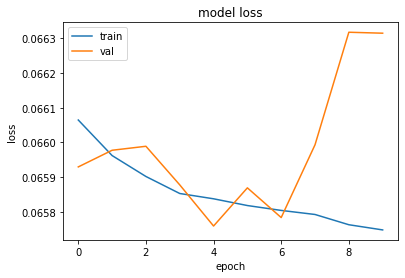

In [ ]:
#for plotting loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Example of using the model to predict a single trajectory


In [ ]:
#Send a single trajectory through the model using model.predict
y=np.expand_dims(dataX_batches[0][0:50], axis=0)
predict = model.predict(y)


1/1 [==============================] - 0s 25ms/step


In [ ]:
dataframe_traj=pd.DataFrame(dataX_batches[0][0:50], columns=['distance', 'bearing', 'temp','unix_time', 'year_clock_x', 'year_clock_y', 'day_clock_x', 'day_clock_y']) 

dataframe_traj[['distance', 'bearing', 'temp']] = scaler.inverse_transform(dataframe_traj[['distance', 'bearing', 'temp']])


predict_traj = np.squeeze(predict)
dataframe_predict=pd.DataFrame(predict_traj , columns=['distance', 'bearing','temp','unix_time', 'year_clock_x', 'year_clock_y', 'day_clock_x', 'day_clock_y']) 
dataframe_predict[['distance', 'bearing', 'temp']] = scaler.inverse_transform(dataframe_predict[['distance', 'bearing','temp']])


dataframe_traj_actual=pd.DataFrame(dataY_batches[0][0:50], columns=['distance', 'bearing', 'temp','unix_time', 'year_clock_x', 'year_clock_y', 'day_clock_x', 'day_clock_y']) 

dataframe_traj_actual[['distance', 'bearing', 'temp']] = scaler.inverse_transform(dataframe_traj_actual[['distance', 'bearing', 'temp']])


In [ ]:
print('This is the trajectory we fed into the model')
dataframe_traj

This is the trajectory we fed into the model


,lat,long,temp,unix_time,year_clock_x,year_clock_y,day_clock_x,day_clock_y
0,3.950551e+06,0.000000,158.507297,0.000000,0.999852,0.017213,0.991445,0.130526
1,3.950551e+06,246.584522,223.424448,0.001344,0.999852,0.017213,0.923880,0.382683
2,3.947794e+06,241.854935,225.680012,0.002688,0.999852,0.017213,0.793353,0.608761
3,3.947301e+06,238.520540,227.432795,0.004032,0.999852,0.017213,0.608761,0.793353
4,3.943630e+06,235.128270,229.446190,0.005376,0.999852,0.017213,0.382683,0.923880
5,3.944164e+06,231.658999,231.378859,0.006720,0.999852,0.017213,0.130526,0.991445
6,3.937840e+06,228.722439,233.091433,0.008065,0.999852,0.017213,-0.130526,0.991445
7,3.936553e+06,225.827917,234.724480,0.009409,0.999852,0.017213,-0.382683,0.923880
8,3.928400e+06,222.687876,235.745972,0.010753,0.999852,0.017213,-0.608761,0.793353
9,3.925094e+06,220.784802,236.517646,0.012097,0.999852,0.017213,-0.793353,0.608761


In [ ]:
print('These are the actual steps')
dataframe_traj_actual

These are the actual steps


,lat,long,temp,unix_time,year_clock_x,year_clock_y,day_clock_x,day_clock_y
0,3.526842e+06,171.521674,226.402359,0.134409,0.996298,0.085965,0.382683,0.923880
1,3.537067e+06,164.561165,225.089764,0.135753,0.996298,0.085965,0.130526,0.991445
2,3.544509e+06,158.520784,224.071407,0.137097,0.996298,0.085965,-0.130526,0.991445
3,3.548454e+06,155.401629,223.615517,0.138441,0.996298,0.085965,-0.382683,0.923880
4,3.551279e+06,154.869726,223.087555,0.139785,0.996298,0.085965,-0.608761,0.793353
5,3.551520e+06,155.409365,222.642098,0.141129,0.996298,0.085965,-0.793353,0.608761
6,3.549618e+06,158.117099,222.361270,0.142473,0.996298,0.085965,-0.923880,0.382683
7,3.544135e+06,162.951319,222.707637,0.143817,0.996298,0.085965,-0.991445,0.130526
8,3.533403e+06,169.471194,224.208687,0.145161,0.996298,0.085965,-0.991445,-0.130526
9,3.528306e+06,177.237749,226.996129,0.146505,0.996298,0.085965,-0.923880,-0.382683
